In [2]:
%load_ext autoreload
%autoreload 2

import splitwavepy as sw
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# Bootstrapping

Here I suggest a new method for estimating errors in shear wave splitting using bootstrapping.  This method is applicable to any of the widely used grid search algorithms used to measure shear wave splitting.

Error estimation for the transverse minimisation and eigenvalue methods of Silver and Chan has traditionally been achieved using an F-statistic.  The idea is that the noise is gaussian such that its energy is drawn from a Chi-square distribution.  The F-test determines the level of energy on the transverse component that is drawn from the chi-2 distribution to within 95% confidence.  Knowledge of the number of degrees of freedom is required to determine the F distribution.  Walsh et al recently reviewed the ndf calculation of Silver and Chan and suggested an amendment to the formula used to calculate the ndf directly from the data.

Two methods have been proposed for error estimation for the cross-correlation method.  One uses the Fisher transform on the correlation coefficients, the other ...

Previously Sandvol and Hearn suggested a bootstrapping method which differs from the method I develop here.  Their method uses repetition of the measurement using randomly generated noise to generate an array of best fitting $\phi$ and $\delta t$ parameters.  The errors are estimated from the spread in the array of parameters.

I suggest a simpler, computationally cheaper method, that is conceptually closer to the more traditional methods.  The method does not repeatedly grid search for $\phi$ and $\delta t$ but simply calculates the relevant test statistic at the pre-determined 'best' node.  It relies on the fact that the underlying functions used in the grid search do not rely on the order of the points.  Then many bootstrap samples of the windowed data are generated by randomly sampling from the windowed data with replacement.  The function, e.g. the energy on the transverse component, is simply calculated for each bootstrap sample.  The value of the function and its 95% confidence contour can then be calculated directly from the spread.



In [3]:
a = sw.Data(delta=0.02, noise=0.1, pol=0, split=(40,0.6))
a.plot()

In [7]:
b = a.Split(pol=0, lags=(0.8,))
# b.sc.plot()

In [7]:
x, y = b._bootstrap_prep()
vals = b._bootstrap_loop(x, y, n=10000)
# sig1 = vals[:,0]
# sig2 = vals[:,1]

# Bootstrap sample distribution

For each bootstrap sample we calculate the ratio of the energy on the radial to the energy on the transverse component.  The distribution for all the values is shown by the histogram below.  The central 95% of values defines the value to with 95% confidence.  The lower bound, at the 2.5% percentile, is the value of interest and is plotted by the black line, this value defined the value of the statistic at the 95% confidence contour.

In [8]:
plt.hist(vals,100)
plt.xlabel('$\sigma_1/\sigma_2$')
plt.ylabel('Count')
plt.title('Bootstrap sample distribution')
# for level in range(0,55,5):
# plt.axvline(np.percentile(vals,2.5),color='k')
plt.show()

# Use kernel density estimation to smooth the distribution obtained from bootstrapping

In [9]:
kde = sw.core.core.kde(vals)

plt.hist(vals,100,density=True, alpha=0.5)

# points to plot kde along
x_d = np.linspace(0.8 * np.min(vals), 1.1 * np.max(vals), 1000)

plt.fill_between(x_d, kde.pdf(x_d), alpha=0.5)
plt.ylabel('probability density')
plt.xlabel('$\sigma_1/\sigma_2$')
plt.show()

# Estimating the probability density surface

By kernel density estimation we have generated a probability density function for possible values of the test statistic at the 'best' node point.  We can map the pdf to the gridsearch to generate something akin to a pdf surface for the measurement.

In [10]:
# for each node in the map find the associated
# probability density from the kde.
ravelvals = np.ravel(b.lam1/b.lam2)
pdf = kde.pdf(ravelvals).reshape(b.lam1.shape)
# normalise so that whole surface weighs 1
# pdf = pdf / np.sum(pdf) 

# plot
degs, lags = b._grid_degs_lags()
plt.contourf(lags, degs, pdf, 50, cmap='magma')
plt.colorbar()
plt.contour(lags, degs, b.pdf, levels=[b.conf95level])
plt.title('Unscaled PDF')
plt.show()

Is 95% of the weight inside the 95% confidence contour?

In [11]:
cumsum = np.cumsum(np.sort(ravelvals))/np.sum(ravelvals)
pdfsum = np.cumsum(kde.pdf(np.sort(ravelvals)))/np.sum(kde.pdf(ravelvals))
smallvals = vals[vals<=ravelvals.max()]
conflevel = np.cumsum(kde.pdf(np.sort(smallvals)))/np.sum(kde.pdf(smallvals))
# plt.plot(np.sort(ravelvals), cumsum, label='$\sigma_1/\sigma_2$ weight', alpha=0.8)
plt.plot(np.sort(ravelvals), pdfsum, label='surface weight', alpha=0.8)
plt.plot(np.sort(smallvals), conflevel, label='bootstrap weight',alpha=0.8)
plt.title('Cumulative sum of weights')
plt.xlabel('$\sigma_1/\sigma_2$')
plt.ylabel('Cumulative Density')
plt.legend()
plt.show()

In [12]:
# surface density

surfkde = sw.core.core.kde(np.sort(ravelvals))

# histogram
plt.hist(np.sort(ravelvals),100,density=True, alpha=0.5)

# points to plot kde along
x_d = np.linspace(0.8 * np.min(ravelvals), 1.1 * np.max(ravelvals), 1000)

plt.fill_between(x_d, surfkde.pdf(x_d), alpha=0.5)
plt.ylabel('surface density')
plt.xlabel('$\sigma_1/\sigma_2$')
plt.show()


In [13]:
denscorr = np.sort(kde.pdf(ravelvals)/surfkde.pdf(ravelvals))
cumdc = np.cumsum(denscorr)/np.sum(denscorr)
cumsum = np.cumsum(np.sort(ravelvals))/np.sum(ravelvals)
pdfsum = np.cumsum(kde.pdf(np.sort(ravelvals)))/np.sum(kde.pdf(ravelvals))
smallvals = vals[vals<=ravelvals.max()]
conflevel = np.cumsum(kde.pdf(np.sort(smallvals)))/np.sum(kde.pdf(smallvals))
# plt.plot(np.sort(ravelvals), cumsum, label='$\sigma_1/\sigma_2$ weight', alpha=0.8)
plt.plot(np.sort(ravelvals), pdfsum, label='surface weight', alpha=0.8)
plt.plot(np.sort(ravelvals), cumdc, label='denscorrect', alpha=0.8)
plt.plot(np.sort(smallvals), conflevel, label='bootstrap weight',alpha=0.8)
plt.title('Cumulative sum of weights')
plt.xlabel('$\sigma_1/\sigma_2$')
plt.ylabel('Cumulative Density')
plt.legend()
plt.show()

In [14]:
denscorr = np.sort(kde.pdf(ravelvals)/surfkde.pdf(ravelvals))
cumdc = np.cumsum(denscorr)/np.sum(denscorr)
cumsum = np.cumsum(np.sort(ravelvals))/np.sum(ravelvals)
pdfsum = np.cumsum(kde.pdf(np.sort(ravelvals)))/np.sum(kde.pdf(ravelvals))
smallvals = vals[vals<=ravelvals.max()]
conflevel = np.cumsum(kde.pdf(np.sort(smallvals)))/np.sum(kde.pdf(smallvals))
# plt.plot(np.sort(ravelvals), cumsum, label='$\sigma_1/\sigma_2$ weight', alpha=0.8)
plt.plot(np.sort(ravelvals), pdfsum, label='surface weight', alpha=0.8)
plt.plot(np.sort(ravelvals), cumdc, label='denscorrect', alpha=0.8)
plt.plot(np.sort(smallvals), conflevel, label='bootstrap weight',alpha=0.8)
plt.title('Cumulative sum of weights')
plt.xlabel('$\sigma_1/\sigma_2$')
plt.ylabel('Cumulative Density')
plt.legend()
plt.show()

# F-test

In [15]:
from scipy import stats

In [16]:
lam2min = b.lam2.min()
ndf = b.ndf()
k = 2
R = ((b.lam2 - lam2min)/k) / (lam2min/(ndf-k))

In [17]:
degs, lags = b._grid_degs_lags()
plt.contourf(lags, degs, R, 50, cmap='magma')
plt.colorbar()
plt.show()

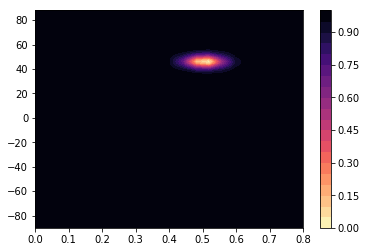

In [18]:
# F = stats.f.cdf(alpha,k,ndf)

R = ((b.lam2 - lam2min)/k) / (lam2min/(ndf-k))
pdf = stats.f.cdf(R,k,ndf)
# pdf = pdf / np.sum(pdf)
degs, lags = b._grid_degs_lags()
plt.contourf(lags, degs, pdf, 20, cmap='magma_r')
plt.colorbar()
# plt.contour(lags, degs, b.lam2, levels=[b.conf95level])
plt.show()

In [19]:
R = ((b.lam2 - lam2min)/k) / (lam2min/(ndf-k))
pdf = stats.f.pdf(R,k,ndf)
# pdf = pdf / np.sum(pdf)
degs, lags = b._grid_degs_lags()
plt.contourf(lags, degs, pdf, 20, cmap='magma')
plt.colorbar()
# plt.contour(lags, degs, b.lam2, levels=[b.conf95level])
plt.show()

/Users/jackwalpole/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:1429: RuntimeWarning: divide by zero encountered in log
  lPx = m/2 * np.log(m) + n/2 * np.log(n) + (n/2 - 1) * np.log(x)
/Users/jackwalpole/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:1429: RuntimeWarning: invalid value encountered in multiply
  lPx = m/2 * np.log(m) + n/2 * np.log(n) + (n/2 - 1) * np.log(x)


In [20]:
R.min()

0.0

# Full bootstrapping surface

In [56]:
# lags=b.lags[::5], degs=b.degs[::10]
out = b._bootstrap_grid(lags=b.lags[::5], degs=b.degs[::10], n=100)


In [58]:
plt.hist(out[0][0],50)
plt.show()

In [55]:
len(out)

90

In [26]:
np.sum(b.pdf)

4.7938190737477537

In [27]:
a.plot()

In [28]:
c = a.Q()

In [31]:
np.sum(c.pdf)

1523.4085158273904

In [33]:
np.sum(c.xc.pdf)

1516.7284346590041

In [35]:
c.xc.plot(vals=c.xc.pdf)